In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# these come with python
import io
import zipfile
import functools
import datetime

# for downloading
import nbformat
import requests
%matplotlib inline

In [2]:
def execute_notebook(nbfile):    
    with io.open(nbfile,encoding="utf8") as f:
        nb = nbformat.read(f, as_version=4)
    
    ip = get_ipython()
    
    for cell in tqdm(nb.cells):
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.source)

In the notebook 'retrieve timeseries from webservice RWS' the file stationData.h5 is created. The file contains high-frequency data of sea water levels along the Dutch coast. The data are subdivided into years. Here we access and read the file. 

In [132]:
hdf_file = Path('stationData.h5')
if hdf_file.is_file():
    hdf = pd.HDFStore(str(hdf_file)) # depends on PyTables
    keys = hdf.keys()
else:
    print ('create stationData.h5 first, uncomment lines below, get a cup of coffee, as this takes hours')
#     execute_notebook('retrieve timeseries from webservice RWS.ipynb')
#     hdf_file = Path('stationData.h5')
#     if hdf_file.is_file():
#         hdf = pd.HDFStore(hdf_file) # depends on PyTables
#         keys = hdf.keys()  

In the notebook 'retrieve timeseries from webservice PSMSL' the dataframe `df_psmsl` is created. This file contains monthly metric waterlevel data of sea water levels along the Dutch coast as collected on-the-fly from PSMSL website. The converted DataFrame is in cm+NAP.

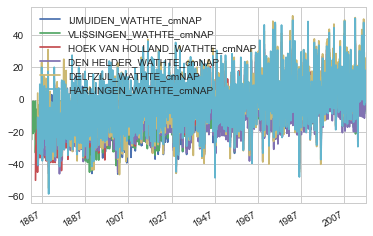

In [134]:
execute_notebook('retrieve timeseries from webservice PSML.ipynb')
# resulted DataFrame available as: df_psmsl

We show some cross-sections of the data.

In [135]:
hdf['/VLISSGN/year1870']

,WATHTE_cmNAP
Tijdstip,
1870-01-01 07:40:00,-116.0
1870-01-02 07:40:00,-181.0
1870-01-03 07:40:00,-179.0
1870-01-04 07:40:00,-162.0
1870-01-05 07:40:00,-104.0
1870-01-06 07:40:00,-46.0
1870-01-07 07:40:00,-1.0
1870-01-08 07:40:00,64.0
1870-01-09 07:40:00,110.0


In [136]:
#columns = ['DELFZL', 'DENHDR', 'HARLGN', 'HOEKVHLD', 'IJMDBTHVN', 'IJMDNDSS', 'VLISSGN']
columns = ['VLISSGN']
index_year = pd.date_range('1850','2018', freq='A')
index_month = pd.date_range('1850','2018', freq='M')
df_year = pd.DataFrame(index=index_year, columns=columns, dtype=float)
df_month = pd.DataFrame(index=index_month, columns=columns, dtype=float)

We convert the HDFStore into some dataframes that can be easily accessed later on.

In [137]:
def convert_raw_df(hdf,columns,index_year,index_month,df_year,df_month):
    df_raw = pd.DataFrame()
    for station in tqdm(columns):
        print (station+' ', end='')
        for year in index_year:        
            key = '/'+station+'/year'+str(year.year)
            if key in keys:
                print ('.',end='')
                if hdf[key].isnull().sum()[0] > 0:
                    print (key)
                df_raw = df_raw.append(hdf[key])
                annual_mean = hdf[key].astype(float).mean()[0]
                monthly_mean = hdf[key].resample('M', how = 'mean')
                df_year.set_value(str(year), station, annual_mean)
                df_month.loc[monthly_mean.index,station] = monthly_mean.as_matrix().flatten()
        print ('✓')
    return(df_raw)

In [138]:
columns = ['VLISSGN']
df_raw = convert_raw_df(hdf,columns,index_year,index_month,df_year,df_month)
df_raw_M = df_raw.resample('M', how = 'mean')
df_raw.head()

VLISSGN .

c:\python35\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()


........................................................................................................................../VLISSGN/year2016
./VLISSGN/year2017
✓



c:\python35\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  app.launch_new_instance()


,WATHTE_cmNAP
Tijdstip,
1863-09-01 07:40:00,-112.0
1863-09-02 07:40:00,-62.0
1863-09-03 07:40:00,4.0
1863-09-04 07:40:00,61.0
1863-09-05 07:40:00,100.0


In [139]:
# since working with df_momth introduces spikes, we resample to monthly mean values using the raw dataframe. This i
df_raw_M = df_raw.resample('M', how = 'mean')

c:\python35\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  from ipykernel import kernelapp as app


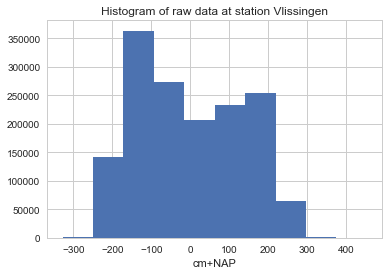

In [140]:
# histogram for the raw values to get insight in the distribution over the period requested
xmin = datetime.datetime(1890,1,1)
xmax = datetime.datetime(2009,12,31)

df_raw.columns = ['Histogram of raw data at station Vlissingen']
ax = df_raw[(df_raw.index>xmin) & (df_raw.index<xmax)].hist()
ax.flatten()[0].set_xlabel("cm+NAP")

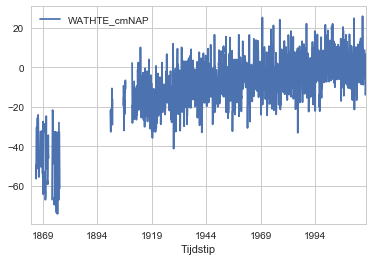

In [141]:
df_raw_M.plot()

Differences have become minimal for this period. Quick check if it is the same for the period 1940 and 1970

In [142]:
df_psmsl.columns

Index(['IJMUIDEN_WATHTE_cmNAP', 'VLISSINGEN_WATHTE_cmNAP',
       'HOEK VAN HOLLAND_WATHTE_cmNAP', 'DEN HELDER_WATHTE_cmNAP',
       'DELFZIJL_WATHTE_cmNAP', 'HARLINGEN_WATHTE_cmNAP'],
      dtype='object')

In [42]:
df_raw_M.columns = ['VLISSGN']

In [106]:
def get_sel_seriesRWS(df_raw_M, xmin, xmax):
    raw_dates = []
    for raw_date in df_raw_M.loc[xmin:xmax].index:
        rw_date = pd.Timestamp(raw_date.year,raw_date.month,15)
        raw_dates.append(rw_date)
    series_raw_dates = pd.Series(raw_dates)

    new_series_RWS = pd.Series(data =df_raw_M.loc[xmin:xmax].values.flatten(), 
                               index = series_raw_dates.values)
    return new_series_RWS

Compare the monthly metric data from PSMSL and the monthly resmapled data from raw observations through the RWS webservice

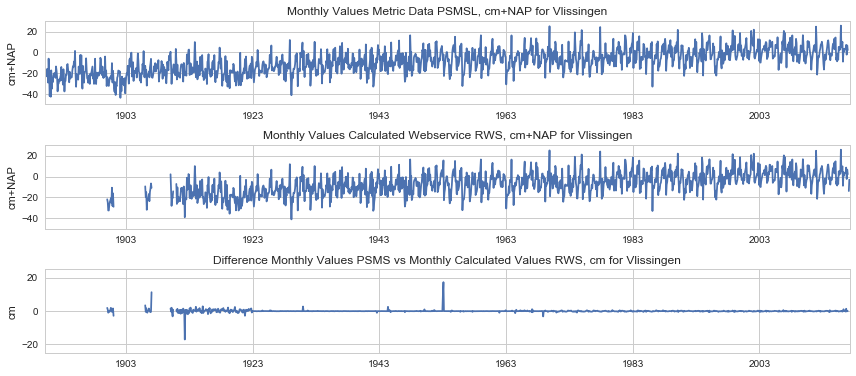

In [114]:
## range of period without major spikes
xmin = datetime.datetime(1890,4,1)
xmax = datetime.datetime(2017,4,1)
series_raw_M = get_sel_seriesRWS(df_raw_M, xmin, xmax)
plt.figure(figsize=(12,12))
plt.subplot(711)
plt.plot(df_psmsl.index, df_psmsl['VLISSINGEN_WATHTE_cmNAP'])
plt.ylabel('cm+NAP')
plt.ylim(-50,30)
plt.xlim(xmin,xmax)
plt.title('Monthly Values Metric Data PSMSL, cm+NAP for Vlissingen')

plt.subplot(712)
plt.plot(series_raw_M.index, df_raw_M['VLISSGN'].loc[xmin:xmax])
plt.ylim(-50,30)
plt.xlim(xmin,xmax)
plt.ylabel('cm+NAP')
plt.title('Monthly Values Calculated Webservice RWS, cm+NAP for Vlissingen')

plt.subplot(713)
dif_series = (series_raw_M - df_psmsl['VLISSINGEN_WATHTE_cmNAP'].loc[xmin:xmax])
plt.plot(dif_series.index,dif_series.values)
plt.ylim(-25,25)
plt.xlim(xmin,xmax)
plt.ylabel('cm')
plt.title('Difference Monthly Values PSMS vs Monthly Calculated Values RWS, cm for Vlissingen')

plt.tight_layout()

The diagram shows a single big spike around 1953, at Vlissingen. This might be the North Sea flood of 1953. 

Another detailed look at the North Sea Flood of 1953, it is somehow surprising that this spike in the North Sea Flood of 1953 is not present in the PSMSL Monthy metric data.

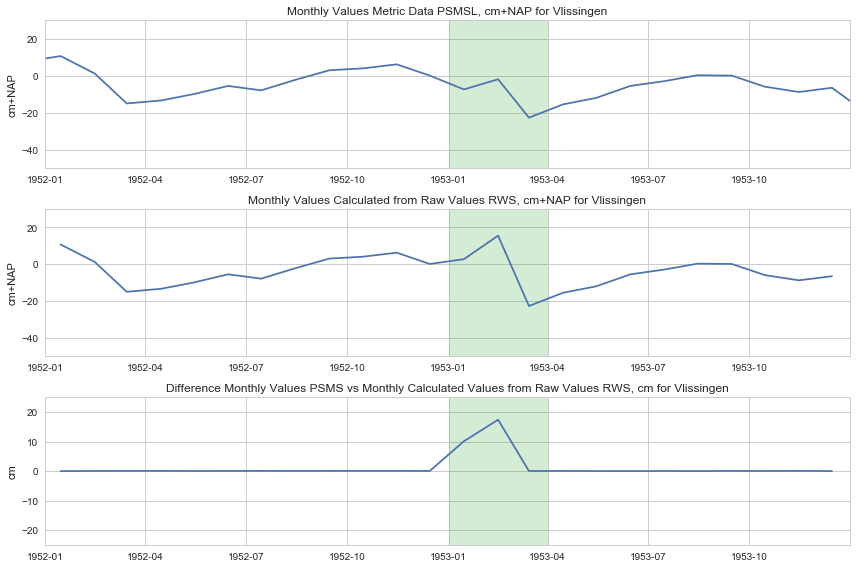

In [118]:
# xmin = datetime.datetime(1890,1,1)
# xmax = datetime.datetime(2016,12,31)
xmin = datetime.datetime(1952,1,1)
xmax = datetime.datetime(1953,12,31)
series_raw_M = get_sel_seriesRWS(df_raw_M, xmin, xmax)
plt.figure(figsize=(12,8))

plt.subplot(311)
plt.plot(df_psmsl.index, df_psmsl['VLISSINGEN_WATHTE_cmNAP'])
plt.axvspan(datetime.datetime(1953,1,1), datetime.datetime(1953,4,1), facecolor='#2ca02c', alpha=0.2)
plt.ylabel('cm+NAP')
plt.ylim(-50,30)
plt.xlim(xmin,xmax)
plt.title('Monthly Values Metric Data PSMSL, cm+NAP for Vlissingen')

plt.subplot(312)
plt.plot(series_raw_M.index, series_raw_M.values)
plt.axvspan(datetime.datetime(1953,1,1), datetime.datetime(1953,4,1), facecolor='#2ca02c', alpha=0.2)
plt.ylim(-50,30)
plt.xlim(xmin,xmax)
plt.ylabel('cm+NAP')
plt.title('Monthly Values Calculated from Raw Values RWS, cm+NAP for Vlissingen')

plt.subplot(313)
dif_series = (series_raw_M - df_psmsl['VLISSINGEN_WATHTE_cmNAP'].loc[xmin:xmax])
plt.plot(dif_series.index,dif_series.values)
#plt.plot(df_raw_M['Histogram of raw data at station Vlissingen'].loc[xmin:xmax].index, df_raw_M['Histogram of raw data at station Vlissingen'].loc[xmin:xmax] - (df_psmsl['waterstand'].loc[xmin:xmax]))
plt.axvspan(datetime.datetime(1953,1,1), datetime.datetime(1953,4,1), facecolor='#2ca02c', alpha=0.2)
plt.ylim(-25,25)
plt.xlim(xmin,xmax)
plt.ylabel('cm')
plt.title('Difference Monthly Values PSMS vs Monthly Calculated Values from Raw Values RWS, cm for Vlissingen')
plt.tight_layout()

In [129]:
def getdif_maxmean(col_RWS,col_PSMSL,xmin,xmax,hdf,columns,index_year,index_month,df_year,df_month):
    columns = [col_RWS]
    df_raw = convert_raw_df(hdf,columns,index_year,index_month,df_year,df_month)
    df_raw_M = df_raw.resample('M', how = 'mean')

    series_raw_M = get_sel_seriesRWS(df_raw_M, xmin, xmax)
    dif_series = (series_raw_M - df_psmsl[col_PSMSL].loc[xmin:xmax])
    return abs(dif_series).mean(),abs(dif_series).max()    

In [143]:
df_psmsl.columns

Index(['IJMUIDEN_WATHTE_cmNAP', 'VLISSINGEN_WATHTE_cmNAP',
       'HOEK VAN HOLLAND_WATHTE_cmNAP', 'DEN HELDER_WATHTE_cmNAP',
       'DELFZIJL_WATHTE_cmNAP', 'HARLINGEN_WATHTE_cmNAP'],
      dtype='object')

In [144]:
['DELFZL', 'DENHDR', 'HARLGN', 'HOEKVHLD', 'IJMDBTHVN', 'IJMDNDSS', 'VLISSGN']

['DELFZL', 'DENHDR', 'HARLGN', 'HOEKVHLD', 'IJMDBTHVN', 'IJMDNDSS', 'VLISSGN']

In [145]:
xmin = datetime.datetime(1890,1,1)
xmax = datetime.datetime(2017,12,31)

abs_dif_mean_list = []
abs_dif_max_list= []
name_list = []

col_RWS='IJMDBTHVN' 
col_PSMSL='IJMUIDEN_WATHTE_cmNAP'
abs_dif_mean, abs_dif_max = getdif_maxmean(col_RWS,col_PSMSL,xmin,xmax,hdf,columns,index_year,index_month,df_year,df_month)
abs_dif_mean_list.append(abs_dif_mean)
abs_dif_max_list.append(abs_dif_max)
name_list.append(col_RWS)

col_RWS='VLISSGN' 
col_PSMSL='VLISSINGEN_WATHTE_cmNAP'
abs_dif_mean, abs_dif_max = getdif_maxmean(col_RWS,col_PSMSL,xmin,xmax,hdf,columns,index_year,index_month,df_year,df_month)
abs_dif_mean_list.append(abs_dif_mean)
abs_dif_max_list.append(abs_dif_max)
name_list.append(col_RWS)

col_RWS='HOEKVHLD' 
col_PSMSL='HOEK VAN HOLLAND_WATHTE_cmNAP'
abs_dif_mean, abs_dif_max = getdif_maxmean(col_RWS,col_PSMSL,xmin,xmax,hdf,columns,index_year,index_month,df_year,df_month)
abs_dif_mean_list.append(abs_dif_mean)
abs_dif_max_list.append(abs_dif_max)
name_list.append(col_RWS)

col_RWS='DENHDR' 
col_PSMSL='DEN HELDER_WATHTE_cmNAP'
abs_dif_mean, abs_dif_max = getdif_maxmean(col_RWS,col_PSMSL,xmin,xmax,hdf,columns,index_year,index_month,df_year,df_month)
abs_dif_mean_list.append(abs_dif_mean)
abs_dif_max_list.append(abs_dif_max)
name_list.append(col_RWS)

col_RWS='DELFZL' 
col_PSMSL='DELFZIJL_WATHTE_cmNAP'
abs_dif_mean, abs_dif_max = getdif_maxmean(col_RWS,col_PSMSL,xmin,xmax,hdf,columns,index_year,index_month,df_year,df_month)
abs_dif_mean_list.append(abs_dif_mean)
abs_dif_max_list.append(abs_dif_max)
name_list.append(col_RWS)

col_RWS='HARLGN' 
col_PSMSL='HARLINGEN_WATHTE_cmNAP'
abs_dif_mean, abs_dif_max = getdif_maxmean(col_RWS,col_PSMSL,xmin,xmax,hdf,columns,index_year,index_month,df_year,df_month)
abs_dif_mean_list.append(abs_dif_mean)
abs_dif_max_list.append(abs_dif_max)
name_list.append(col_RWS)

IJMDBTHVN .

c:\python35\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()


..................................../IJMDBTHVN/year2016
./IJMDBTHVN/year2017
✓



c:\python35\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()


VLISSGN .........................................................................................................................../VLISSGN/year2016
./VLISSGN/year2017
✓

HOEKVHLD .................../HOEKVHLD/year1947
........./HOEKVHLD/year1956
............................................................/HOEKVHLD/year2016
./HOEKVHLD/year2017
✓

DENHDR ...................................................................................../DENHDR/year2016
./DENHDR/year2017
✓

DELFZL ........................................................................................................................................../DELFZL/year2016
./DELFZL/year2017
✓

HARLGN ..................../HARLGN/year1957
.........................................................../HARLGN/year2016
./HARLGN/year2017
✓



In [156]:
station_difs = pd.DataFrame([abs_dif_mean_list,abs_dif_max_list], columns=name_list, index=['absolute mean difference (cm)','absolute max difference (cm)'])
station_difs

,IJMDBTHVN,VLISSGN,HOEKVHLD,DENHDR,DELFZL,HARLGN
absolute mean difference (cm),0.394272,0.245511,0.532790,0.130802,0.606863,0.143925
absolute max difference (cm),126.800000,17.378134,44.345186,15.859767,41.565789,17.009375


In [157]:
station_difs.mean(axis=1)

absolute mean difference (cm)     0.342360
absolute max difference (cm)     43.826375
dtype: float64

Conclusion: Numeric Monthly PSMSL data cannot be reproduced exactly using the RWS data available through their webservices. Certain validation and processing methods have been applied on the raw values before RWS has submitted their resampled monthly data to PSMSL.

N.B. Resampling of RWS webservice data should take place on the full time series and not year by year as it introduces spikes at the annual change.